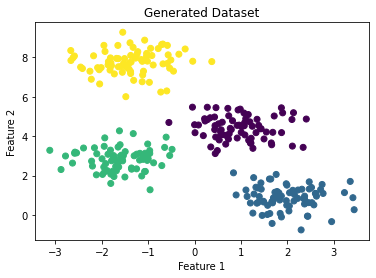

In [1]:
import numpy as np  
from sklearn.datasets import make_blobs  
import matplotlib.pyplot as plt  
  
# 生成模拟数据集  
np.random.seed(0)  # 设置随机种子以便结果可复现  
n_samples = 300  # 样本数量  
n_features = 2  # 特征维度  
centers = 4  # 聚类中心数量  
X, y = make_blobs(n_samples=n_samples, n_features=n_features, centers=centers, cluster_std=0.60, random_state=0)  
  
# 可视化生成的数据  
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', marker='o')  
plt.title('Generated Dataset')  
plt.xlabel('Feature 1')  
plt.ylabel('Feature 2')  
plt.show()

E:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


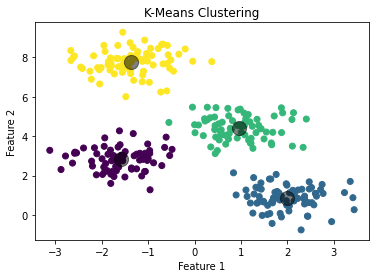

In [2]:
from sklearn.cluster import KMeans  
  
# K-Means算法  
kmeans = KMeans(n_clusters=centers, init='random', n_init=10, max_iter=300, random_state=0)  
y_kmeans = kmeans.fit_predict(X)  
  
# 可视化K-Means聚类结果  
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, cmap='viridis', marker='o')  
centers = kmeans.cluster_centers_  
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)  
plt.title('K-Means Clustering')  
plt.xlabel('Feature 1')  
plt.ylabel('Feature 2')  
plt.show()

In [4]:
from sklearn.cluster import AgglomerativeClustering  
from itertools import combinations  
  
# 设定Canopy的T1和T2阈值  
t1 = 0.3  
t2 = 0.8  
  
# 使用AgglomerativeClustering模拟Canopy的初步聚类  
def canopy_preprocessing(X, t1, t2):  
    # 计算所有点对之间的距离  
    distances = []  
    for i, j in combinations(range(X.shape[0]), 2):  
        dist = np.linalg.norm(X[i] - X[j])  
        distances.append((i, j, dist))  
    distances = np.array(distances)  
      
    # 模拟Canopy算法，根据距离阈值进行初步聚类  
    canopy_clusters = []  
    for i in range(X.shape[0]):  
        cluster = [i]  
        for j, (idx1, idx2, dist) in enumerate(distances):  
            if idx1 == i and dist <= t2:  
                if idx2 not in cluster:  
                    cluster.append(idx2)  
        if all(dist > t1 for _, _, dist in distances[distances[:, 0] == i] if dist <= t2):  
            canopy_clusters.append(cluster)  
      
    return np.array(canopy_clusters)  
  
# 执行Canopy预处理  
canopy_clusters = canopy_preprocessing(X, t1, t2)  
  
# 基于Canopy的初步聚类结果，选择质心作为K-Means的初始质心  
initial_centroids = np.vstack([X[np.random.choice(cluster)] for cluster in canopy_clusters])  
  
# 使用选定的初始质心执行K-Means算法  
kmeans_canopy = KMeans(n_clusters=len(canopy_clusters), init=initial_centroids, n_init=1, max_iter=300)  
y_kmeans_canopy = kmeans_canopy.fit_predict(X)  
  
# 可视化结合使用的聚类结果  
plt.scatter

C:\Users\DELL\AppData\Local\Temp/ipykernel_14596/2503173219.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(canopy_clusters)


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [7]:

import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
from sklearn.cluster import KMeans  
from sklearn.datasets import make_blobs  
from sklearn.preprocessing import StandardScaler  
from sklearn.metrics import pairwise_distances_argmin_min  
  
# 生成模拟数据  
n_samples = 300  
random_state = 0  
X, y = make_blobs(n_samples=n_samples, centers=4, random_state=random_state)  
  
# 标准化数据  
X = StandardScaler().fit_transform(X)  
  
# 定义一个简化的Canopy算法  
def canopy_clustering(X, t1, t2):  
    n_samples = X.shape[0]  
    distances, indices = pairwise_distances_argmin_min(X, axis=1)  
    labels = np.full(n_samples, -1)  
    clusters = []  
    centers = []  
    for i in range(n_samples):  
        if labels[i] != -1:  
            continue  
        cluster = [i]  
        k = 0  
        while k < len(cluster):  
            j = cluster[k]  
            if labels[j] == -1:  
                labels[j] = len(clusters)  
                neighbors = indices[j][distances[j] < t1]  
                cluster.extend(neighbors[labels[neighbors] == -1])  
            k += 1  
        clusters.append(cluster)  
        centers.append(X[cluster].mean(axis=0))  
      
    # 合并相近的簇  
    clusters_to_merge = []  
    for i in range(len(centers)):  
        for j in range(i + 1, len(centers)):  
            if np.linalg.norm(centers[i] - centers[j]) < t2:  
                clusters_to_merge.append((i, j))  
      
    merged_clusters = []  
    merged_centers = []  
    for i in range(len(clusters)):  
        if i not in [c[0] for c in clusters_to_merge]:  
            merged_clusters.append(clusters[i])  
            merged_centers.append(centers[i])  
        else:  
            for j in range(i + 1, len(clusters)):  
                if (i, j) in clusters_to_merge or (j, i) in clusters_to_merge:  
                    merged_clusters[-1].extend(clusters[j])  
                    merged_centers[-1] = np.mean(np.vstack([merged_centers[-1], centers[j]]), axis=0)  
      
    labels_merged = np.full(n_samples, -1)  
    for i, cluster in enumerate(merged_clusters):  
        labels_merged[cluster] = i  
      
    return labels_merged, np.array(merged_centers)  
  
# 使用简化的Canopy算法进行预聚类  
t1 = 3  
t2 = 2.5  
labels_canopy, centers_canopy = canopy_clustering(X, t1, t2)  
  
# 使用K-Means在Canopy的簇中心上进行聚类  
kmeans = KMeans(n_clusters=len(centers_canopy), init=centers_canopy)  
kmeans.fit(X)  
labels_final = kmeans.labels_  
  
# 可视化结果  
def plot_results(X, labels, title):  
    plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis')  
    plt.title(title)  
    plt.show()  
  
plot_results(X, labels=labels_canopy, title="Canopy Pre-Clustering")  
plot_results(X, labels=labels_final, title="Final Clustering with K-Means on Canopy Centers")


TypeError: pairwise_distances_argmin_min() missing 1 required positional argument: 'Y'